# Projets Time-Series :
---
Ce projet consiste en la prevision de consomation electrique au court et moyen terme de certains pays européens et aussi de prévoir la production minimale et maximale d'unités de production utilisant l'energie solaire et/ou éolienne pour permettre un mix energetique. 

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import os
from datetime import datetime
import csv
import requests
import bib_outils as bo
import bib_outils.ts as utils # bibliothèque personalisée

In [6]:
seps = {'inventory_of_generation': '\t', 
              'inventory_of_transmission': ',', 
              'monthly_domestic_values': '\t',
              'monthly_hourly_load_values': '\t',
              'net_generation_capacity': '\t',
              'physical_energy_power_flows': ';'
            }

In [7]:
annees = [str(i) for i in range(2015, 2025)]
annees

['2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024']

In [8]:
def detect_sep(path, encoding="utf-8"):
    with open(path, "r", encoding=encoding) as f:
        sample = f.read(100)
        try:
            dialect = csv.Sniffer().sniff(sample)
            return dialect.delimiter
        except csv.Error:
            return ","

In [9]:
dossier = "sets"
dfs = {}
for fichier in os.listdir(dossier):
    if fichier.endswith((".csv")) and any(annee in fichier for annee in
            annees) and 'net' not in fichier:
        chemin_fichier = os.path.join(dossier, fichier)
        try:

            annee = next((a for a in annees if a in fichier), None)
            if not annee:
                continue
            try:
                if fichier.endswith(".csv"):
                    sep =detect_sep(chemin_fichier)
                    df = pd.read_csv(chemin_fichier, sep=sep)
                else:
                    continue
            except UnicodeDecodeError:
                print(f"Encodage UTF-8 échoué pour {fichier}, tentative avec ISO-8859-1")
                sep = detect_sep(chemin_fichier, encoding="ISO-8859-1")
                df = pd.read_csv(chemin_fichier, sep=sep, encoding="ISO-8859-1")
                
            nom_df = os.path.splitext(fichier)[0]
            dfs[f"df_{nom_df}"] = df
            print(f" Fichier {fichier} chargé → df_{fichier[:-4]}")

        except Exception as e:
            print(f"Erreur avec {fichier} : {e}")


 Fichier inventory_of_generation_2019.csv chargé → df_inventory_of_generation_2019
 Fichier inventory_of_generation_2020.csv chargé → df_inventory_of_generation_2020
 Fichier inventory_of_generation_2021.csv chargé → df_inventory_of_generation_2021
 Fichier inventory_of_generation_2022.csv chargé → df_inventory_of_generation_2022
 Fichier inventory_of_generation_2023.csv chargé → df_inventory_of_generation_2023
 Fichier inventory_of_generation_2024.csv chargé → df_inventory_of_generation_2024
Encodage UTF-8 échoué pour inventory_of_transmission_2019.csv, tentative avec ISO-8859-1
 Fichier inventory_of_transmission_2019.csv chargé → df_inventory_of_transmission_2019
Encodage UTF-8 échoué pour inventory_of_transmission_2020.csv, tentative avec ISO-8859-1
 Fichier inventory_of_transmission_2020.csv chargé → df_inventory_of_transmission_2020
 Fichier inventory_of_transmission_2021.csv chargé → df_inventory_of_transmission_2021
Encodage UTF-8 échoué pour inventory_of_transmission_2022.csv, 

In [10]:
dfs.keys()

dict_keys(['df_inventory_of_generation_2019', 'df_inventory_of_generation_2020', 'df_inventory_of_generation_2021', 'df_inventory_of_generation_2022', 'df_inventory_of_generation_2023', 'df_inventory_of_generation_2024', 'df_inventory_of_transmission_2019', 'df_inventory_of_transmission_2020', 'df_inventory_of_transmission_2021', 'df_inventory_of_transmission_2022', 'df_inventory_of_transmission_2023', 'df_inventory_of_transmission_2024', 'df_monthly_domestic_values_2019', 'df_monthly_domestic_values_2020', 'df_monthly_domestic_values_2021', 'df_monthly_domestic_values_2022', 'df_monthly_domestic_values_2023', 'df_monthly_domestic_values_2024', 'df_monthly_hourly_load_values_2019', 'df_monthly_hourly_load_values_2020', 'df_monthly_hourly_load_values_2021', 'df_monthly_hourly_load_values_2022', 'df_monthly_hourly_load_values_2023', 'df_monthly_hourly_load_values_2024', 'df_physical_energy_power_flows_2019', 'df_physical_energy_power_flows_2020', 'df_physical_energy_power_flows_2021', 'd

In [12]:
dfs['df_monthly_hourly_load_values_2019']['DateUTC'] = pd.to_datetime(dfs['df_monthly_hourly_load_values_2019']['DateUTC'], format="%d-%m-%Y %H:%M").dt.date

In [13]:
dfs['df_monthly_hourly_load_values_2019']['DateUTC'].head()

0    2019-01-01
1    2019-01-01
2    2019-01-01
3    2019-01-01
4    2019-01-01
Name: DateUTC, dtype: object

In [15]:
dfs['df_monthly_hourly_load_values_2020']['DateUTC'] = pd.to_datetime(dfs['df_monthly_hourly_load_values_2020']['DateUTC'], format="%d-%m-%Y %H:%M").dt.date
dfs['df_monthly_hourly_load_values_2020']['DateUTC'].head()

0    2020-01-01
1    2020-01-01
2    2020-01-01
3    2020-01-01
4    2020-01-01
Name: DateUTC, dtype: object

In [17]:
dfs['df_monthly_hourly_load_values_2021']['DateUTC'] = pd.to_datetime(dfs['df_monthly_hourly_load_values_2021']['DateUTC'], format="%d/%m/%Y %H:%M").dt.date
dfs['df_monthly_hourly_load_values_2021']['DateUTC'].head()

0    2021-08-10
1    2021-08-10
2    2021-08-10
3    2021-08-10
4    2021-08-10
Name: DateUTC, dtype: object

In [19]:
dfs['df_monthly_hourly_load_values_2022']['DateUTC'] = pd.to_datetime(dfs['df_monthly_hourly_load_values_2022']['DateUTC'], format="%d/%m/%Y %H:%M").dt.date
dfs['df_monthly_hourly_load_values_2022']['DateUTC'].head()

0    2022-01-01
1    2022-01-02
2    2022-01-02
3    2022-01-02
4    2022-01-02
Name: DateUTC, dtype: object

In [22]:
dfs['df_monthly_hourly_load_values_2023']['DateUTC'] = pd.to_datetime(dfs['df_monthly_hourly_load_values_2023']['DateUTC'], format="%d-%m-%Y %H:%M").dt.date
dfs['df_monthly_hourly_load_values_2023']['DateUTC'].head()

0    2023-01-01
1    2023-01-01
2    2023-01-01
3    2023-01-01
4    2023-01-01
Name: DateUTC, dtype: object

In [24]:
dfs['df_monthly_hourly_load_values_2024']['DateUTC'] = pd.to_datetime(dfs['df_monthly_hourly_load_values_2024']['DateUTC'], format="%d-%m-%Y %H:%M").dt.date
dfs['df_monthly_hourly_load_values_2024']['DateUTC'].head()

0    2024-01-01
1    2024-01-01
2    2024-01-01
3    2024-01-01
4    2024-01-01
Name: DateUTC, dtype: object

In [25]:

grouped_dfs = defaultdict(list)

for key, df in dfs.items():
    base_name, year = key.rsplit('_', 1)
    df = df.copy()

    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    df['year'] = int(year)
    df['year'] = df['year'].astype(int)

    grouped_dfs[base_name].append(df)

combined_dfs = {
    name: pd.concat(dfs, ignore_index=True)
    for name, dfs in grouped_dfs.items()
}


In [26]:
combined_dfs.keys()

dict_keys(['df_inventory_of_generation', 'df_inventory_of_transmission', 'df_monthly_domestic_values', 'df_monthly_hourly_load_values', 'df_physical_energy_power_flows'])

In [27]:
combined_dfs['df_inventory_of_generation'].columns

Index(['MeasureItem', 'MeasureItemCategoryID', 'MeasureItemID', 'Category',
       'Country', 'Year', 'ProvidedValue', 'ProvidedValueCode',
       'NumberOfUnits', 'CreationDate', 'UpdateDate', 'year'],
      dtype='object')

In [28]:
display(combined_dfs['df_inventory_of_generation'].head(2))
display(combined_dfs['df_inventory_of_generation'].tail(2))

,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,ProvidedValue,ProvidedValueCode,NumberOfUnits,CreationDate,UpdateDate,year
0,Inventory of Generation,9,157,Nuclear,RO,2019.0,1300.0,NaN,2.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
1,Inventory of Generation,9,378,FF_over_400MW,FI,2019.0,565.0,NaN,1.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,ProvidedValue,ProvidedValueCode,NumberOfUnits,CreationDate,UpdateDate,year
1020,Inventory of Generation,9,378,FF_over_400MW,FR,2024.0,8256.0,NaN,17.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
1021,Inventory of Generation,9,381,Hydro_10MW_50MW,IE,2024.0,195.0,NaN,11.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024


In [29]:
for name, df in combined_dfs.items():
    print(f'\n\n{name}: {df.shape}')
    display(df.head())
    display(df.tail())



df_inventory_of_generation: (1022, 12)


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,ProvidedValue,ProvidedValueCode,NumberOfUnits,CreationDate,UpdateDate,year
0,Inventory of Generation,9,157,Nuclear,RO,2019.0,1300.0,NaN,2.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
1,Inventory of Generation,9,378,FF_over_400MW,FI,2019.0,565.0,NaN,1.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
2,Inventory of Generation,9,376,FF_10MW_200MW,PL,2019.0,3697.0,NaN,31.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
3,Inventory of Generation,9,383,Hydro_Over_100MW,CZ,2019.0,1110.0,NaN,6.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
4,Inventory of Generation,9,376,FF_10MW_200MW,RS,2019.0,590.0,NaN,5.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,ProvidedValue,ProvidedValueCode,NumberOfUnits,CreationDate,UpdateDate,year
1017,Inventory of Generation,9,378,FF_over_400MW,DK,2024.0,640.0,NaN,1.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
1018,Inventory of Generation,9,376,FF_10MW_200MW,IT,2024.0,4597.0,NaN,35.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
1019,Inventory of Generation,9,381,Hydro_10MW_50MW,XK,2024.0,68.2,NaN,3.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
1020,Inventory of Generation,9,378,FF_over_400MW,FR,2024.0,8256.0,NaN,17.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
1021,Inventory of Generation,9,381,Hydro_10MW_50MW,IE,2024.0,195.0,NaN,11.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024




df_inventory_of_transmission: (5561, 13)


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,LengthOfCircuits,LengthOfRoutes,NumberOfUnits,ProvidedValue,CreationDate,ProvidedValueCode,year
0,Inventory of Transmission,5,406,ACC_220kV_380kV,AL,2019,NaN,NaN,NaN,NaN,2024-09-17 11:24:51,Not Expected,2019
1,Inventory of Transmission,5,407,ACC_Over_380kV,AL,2019,NaN,NaN,NaN,NaN,2024-09-17 11:24:51,Not Expected,2019
2,Inventory of Transmission,5,400,ACL_110kV_220kV,AL,2019,1699.6,1699.6,NaN,NaN,2024-09-17 11:24:51,NaN,2019
3,Inventory of Transmission,5,401,ACL_220kV,AL,2019,1250.0,1250.0,NaN,NaN,2024-09-17 11:24:51,NaN,2019
4,Inventory of Transmission,5,402,ACL_275kV,AL,2019,NaN,NaN,NaN,NaN,2024-09-17 11:24:51,Not Expected,2019


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,LengthOfCircuits,LengthOfRoutes,NumberOfUnits,ProvidedValue,CreationDate,ProvidedValueCode,year
5556,Inventory of Transmission,5,422,DCC_110kV_220V,TR,2018,NaN,NaN,NaN,NaN,12/06/2019 00:00,Not Expected,2024
5557,Inventory of Transmission,5,424,Comments_1,TR,2018,NaN,NaN,NaN,NaN,12/06/2019 00:00,NaN,2024
5558,Inventory of Transmission,5,425,Comments_2,TR,2018,NaN,NaN,NaN,NaN,12/06/2019 00:00,NaN,2024
5559,Inventory of Transmission,5,426,Comments_3,TR,2018,NaN,NaN,NaN,NaN,12/06/2019 00:00,NaN,2024
5560,Inventory of Transmission,5,427,Comments_4,TR,2018,NaN,NaN,NaN,NaN,12/06/2019 00:00,NaN,2024




df_monthly_domestic_values: (25330, 12)


,MeasureItem,Month,Year,Category,Country,MeasureItemID,CreationDate,Representativity,ProvidedValue,ProvidedValueCode,year,Area
0,Monthly Domestic Values,11,2019,Biomass,RO,B01,2024-05-29 11:56:05,100,43.780900,NaN,2019,NaN
1,Monthly Domestic Values,11,2019,Geothermal,IT,B09,2024-05-29 11:56:05,100,465.635000,NaN,2019,NaN
2,Monthly Domestic Values,3,2019,Wind Offshore,DE,B18,2024-05-29 11:56:05,100,2542.554273,NaN,2019,NaN
3,Monthly Domestic Values,12,2019,Geothermal,ES,B09,2024-05-29 11:56:05,100,0.000000,NaN,2019,NaN
4,Monthly Domestic Values,3,2019,Hydro Water Reservoir,HU,B12,2024-05-29 11:56:05,100,8.866150,NaN,2019,NaN


,MeasureItem,Month,Year,Category,Country,MeasureItemID,CreationDate,Representativity,ProvidedValue,ProvidedValueCode,year,Area
25325,Monthly Domestic Values,8,2024,Fossil Brown coal/Lignite,NaN,B02,2025-03-03 12:12:11,100,410.24482,NaN,2024,XK
25326,Monthly Domestic Values,9,2024,Fossil Brown coal/Lignite,NaN,B02,2025-03-03 12:12:11,100,333.30266,NaN,2024,XK
25327,Monthly Domestic Values,10,2024,Fossil Brown coal/Lignite,NaN,B02,2025-03-03 12:12:11,100,463.49856,NaN,2024,XK
25328,Monthly Domestic Values,11,2024,Fossil Brown coal/Lignite,NaN,B02,2025-03-03 12:12:11,100,500.86794,NaN,2024,XK
25329,Monthly Domestic Values,12,2024,Fossil Brown coal/Lignite,NaN,B02,2025-03-03 12:12:11,100,473.70217,NaN,2024,XK




df_monthly_hourly_load_values: (1833442, 12)


,MeasureItem,DateUTC,DateShort,TimeFrom,TimeTo,CountryCode,Cov_ratio,Value,Value_ScaleTo100,CreateDate,UpdateDate,year
0,Monthly Hourly Load Values,2019-01-01,01-01-2019,00:00,01:00,AT,100,5852.5,5852.5,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
1,Monthly Hourly Load Values,2019-01-01,01-01-2019,01:00,02:00,AT,100,5619.2,5619.2,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
2,Monthly Hourly Load Values,2019-01-01,01-01-2019,02:00,03:00,AT,100,5323.9,5323.9,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
3,Monthly Hourly Load Values,2019-01-01,01-01-2019,03:00,04:00,AT,100,5273.3,5273.3,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
4,Monthly Hourly Load Values,2019-01-01,01-01-2019,04:00,05:00,AT,100,5439.0,5439.0,29-05-2024 11:37:27,29-05-2024 11:37:27,2019


,MeasureItem,DateUTC,DateShort,TimeFrom,TimeTo,CountryCode,Cov_ratio,Value,Value_ScaleTo100,CreateDate,UpdateDate,year
1833437,Monthly Hourly Load Values,2024-12-31,31-12-2024,19:00,20:00,XK,100,1294.19,1294.19,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1833438,Monthly Hourly Load Values,2024-12-31,31-12-2024,20:00,21:00,XK,100,1225.29,1225.29,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1833439,Monthly Hourly Load Values,2024-12-31,31-12-2024,21:00,22:00,XK,100,1195.09,1195.09,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1833440,Monthly Hourly Load Values,2024-12-31,31-12-2024,22:00,23:00,XK,100,1207.07,1207.07,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1833441,Monthly Hourly Load Values,2024-12-31,31-12-2024,23:00,00:00,XK,100,1253.17,1253.17,03-03-2025 12:24:13,03-03-2025 12:24:13,2024




df_physical_energy_power_flows: (48392, 16)


,MeasureItem,Year,Month,Value,ProvidedValue,AVG_Value,FromAreaCode,ToAreaCode,MeasureTime,Direction,Flag,FromAreaMemberType,ToAreaMemberType,year,FromMemberType,ToMemberType
0,Physical Energy & Power Flows,2019,3,336,336,336,RS,MK,Value on 3rd Wed. at 03,Export,Harmonized,M,M,2019,NaN,NaN
1,Physical Energy & Power Flows,2019,3,330,330,330,RS,RO,Value on 3rd Wed. at 03,Import,Harmonized,M,M,2019,NaN,NaN
2,Physical Energy & Power Flows,2019,3,407,407,407,RU,EE,Value on 3rd Wed. at 03,Export,Harmonized,NaM,M,2019,NaN,NaN
3,Physical Energy & Power Flows,2019,3,1393,1393,1393,RU,FI,Value on 3rd Wed. at 03,Export,Harmonized,NaM,M,2019,NaN,NaN
4,Physical Energy & Power Flows,2019,3,473,473,473,RU,LT,Value on 3rd Wed. at 03,Export,Harmonized,NaM,M,2019,NaN,NaN


,MeasureItem,Year,Month,Value,ProvidedValue,AVG_Value,FromAreaCode,ToAreaCode,MeasureTime,Direction,Flag,FromAreaMemberType,ToAreaMemberType,year,FromMemberType,ToMemberType
48387,Physical Energy & Power Flows,2024,8,11,11,11,XK,RS,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
48388,Physical Energy & Power Flows,2024,9,194,194,194,XK,RS,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
48389,Physical Energy & Power Flows,2024,10,247,247,247,XK,RS,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
48390,Physical Energy & Power Flows,2024,11,220,220,220,XK,RS,Value on 3rd Wed. at 11,Export,Harmonized,M,M,2024,NaN,NaN
48391,Physical Energy & Power Flows,2024,12,7,7,7,XK,RS,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN


In [30]:
combined_dfs['df_inventory_of_generation'] = combined_dfs['df_inventory_of_generation']\
    [combined_dfs['df_inventory_of_generation']['Country']=='ES']

combined_dfs['df_inventory_of_transmission'] = combined_dfs['df_inventory_of_transmission']\
    [combined_dfs['df_inventory_of_transmission']['Country']=='ES']

combined_dfs['df_monthly_domestic_values'] = combined_dfs['df_monthly_domestic_values'] \
    [combined_dfs['df_monthly_domestic_values']['Country']=='ES']

combined_dfs['df_monthly_hourly_load_values'] = \
combined_dfs['df_monthly_hourly_load_values'] \
    [combined_dfs['df_monthly_hourly_load_values']['CountryCode']=='ES']

combined_dfs['df_physical_energy_power_flows'] = combined_dfs['df_physical_energy_power_flows']\
    [(combined_dfs['df_physical_energy_power_flows']['FromAreaCode']=='ES') | \
     (combined_dfs['df_physical_energy_power_flows']['ToAreaCode']=='ES')]

In [31]:
for name, df in combined_dfs.items():
    print(f'\n\n{name}: {df.shape}')
    display(df.head())
    display(df.tail())



df_inventory_of_generation: (29, 12)


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,ProvidedValue,ProvidedValueCode,NumberOfUnits,CreationDate,UpdateDate,year
17,Inventory of Generation,9,378,FF_over_400MW,ES,2019.0,11137.0,NaN,25.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
49,Inventory of Generation,9,376,FF_10MW_200MW,ES,2019.0,297.7,NaN,2.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
78,Inventory of Generation,9,377,FF_200MW_400MW,ES,2019.0,22411.0,NaN,70.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
99,Inventory of Generation,9,157,Nuclear,ES,2019.0,7117.2,NaN,7.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019
144,Inventory of Generation,9,383,Hydro_Over_100MW,ES,2019.0,10597.0,NaN,69.0,29-05-2024 00:00:00,29-05-2024 00:00:00,2019


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,ProvidedValue,ProvidedValueCode,NumberOfUnits,CreationDate,UpdateDate,year
921,Inventory of Generation,9,391,Wind_On_Over_1MW,ES,2024.0,579.9,NaN,3.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
930,Inventory of Generation,9,377,FF_200MW_400MW,ES,2024.0,16644.4,NaN,53.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
952,Inventory of Generation,9,157,Nuclear,ES,2024.0,7117.2,NaN,7.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
981,Inventory of Generation,9,385,Solar_Over_1MW,ES,2024.0,3316.2,NaN,16.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024
1001,Inventory of Generation,9,383,Hydro_Over_100MW,ES,2024.0,10597.0,NaN,69.0,03-03-2025 00:00:00,03-03-2025 00:00:00,2024




df_inventory_of_transmission: (162, 13)


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,LengthOfCircuits,LengthOfRoutes,NumberOfUnits,ProvidedValue,CreationDate,ProvidedValueCode,year
216,Inventory of Transmission,5,406,ACC_220kV_380kV,ES,2019,491.228,485.26,NaN,NaN,2024-09-17 11:25:00,NaN,2019
217,Inventory of Transmission,5,407,ACC_Over_380kV,ES,2019,55.050,22.80,NaN,NaN,2024-09-17 11:25:00,NaN,2019
218,Inventory of Transmission,5,400,ACL_110kV_220kV,ES,2019,363.771,294.36,NaN,NaN,2024-09-17 11:25:00,NaN,2019
219,Inventory of Transmission,5,401,ACL_220kV,ES,2019,18906.832,13346.83,NaN,NaN,2024-09-17 11:25:00,NaN,2019
220,Inventory of Transmission,5,402,ACL_275kV,ES,2019,NaN,NaN,NaN,NaN,2024-09-17 11:25:00,Not Expected,2019


,MeasureItem,MeasureItemCategoryID,MeasureItemID,Category,Country,Year,LengthOfCircuits,LengthOfRoutes,NumberOfUnits,ProvidedValue,CreationDate,ProvidedValueCode,year
4908,Inventory of Transmission,5,414,Nw_750kV_400kV_lower,ES,2024,NaN,NaN,NaN,NaN,06/03/2025 11:08,Not Expected,2024
4909,Inventory of Transmission,5,413,Of_PU_>220kV,ES,2024,NaN,NaN,65.0,8.349,06/03/2025 11:08,NaN,2024
4910,Inventory of Transmission,5,412,Of_PU_>275kV,ES,2024,NaN,NaN,NaN,NaN,06/03/2025 11:08,Not Expected,2024
4911,Inventory of Transmission,5,411,Of_PU_>330kV,ES,2024,NaN,NaN,NaN,NaN,06/03/2025 11:08,Not Expected,2024
4912,Inventory of Transmission,5,410,Of_PU_>400kV,ES,2024,NaN,NaN,160.0,87.315,06/03/2025 11:08,NaN,2024




df_monthly_domestic_values: (1260, 12)


,MeasureItem,Month,Year,Category,Country,MeasureItemID,CreationDate,Representativity,ProvidedValue,ProvidedValueCode,year,Area
3,Monthly Domestic Values,12,2019,Geothermal,ES,B09,2024-05-29 11:56:05,100,0.000,NaN,2019,NaN
6,Monthly Domestic Values,7,2019,Fossil Oil shale,ES,B07,2024-05-29 11:56:05,100,0.000,NaN,2019,NaN
7,Monthly Domestic Values,7,2019,Fossil Hard coal,ES,B05,2024-05-29 11:56:05,100,696.411,NaN,2019,NaN
8,Monthly Domestic Values,9,2019,Wind Onshore,ES,B19,2024-05-29 11:56:05,100,3734.680,NaN,2019,NaN
25,Monthly Domestic Values,1,2019,Other,ES,B20,2024-05-29 11:56:05,100,44.397,NaN,2019,NaN


,MeasureItem,Month,Year,Category,Country,MeasureItemID,CreationDate,Representativity,ProvidedValue,ProvidedValueCode,year,Area
18177,Monthly Domestic Values,12,2023,Other renewable,ES,B15,01/03/2024 11:51,100,58.271,NaN,2023,NaN
18178,Monthly Domestic Values,12,2023,Solar,ES,B16,01/03/2024 11:51,100,1857.368,NaN,2023,NaN
18179,Monthly Domestic Values,12,2023,Waste,ES,B17,01/03/2024 11:51,100,182.421,NaN,2023,NaN
18180,Monthly Domestic Values,12,2023,Wind Offshore,ES,B18,01/03/2024 11:51,100,0.000,NaN,2023,NaN
18181,Monthly Domestic Values,12,2023,Wind Onshore,ES,B19,01/03/2024 11:51,100,5744.938,NaN,2023,NaN




df_monthly_hourly_load_values: (52607, 12)


,MeasureItem,DateUTC,DateShort,TimeFrom,TimeTo,CountryCode,Cov_ratio,Value,Value_ScaleTo100,CreateDate,UpdateDate,year
86369,Monthly Hourly Load Values,2019-01-01,01-01-2019,00:00,01:00,ES,100,22699.0,22699.0,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
86370,Monthly Hourly Load Values,2019-01-01,01-01-2019,01:00,02:00,ES,100,21336.0,21336.0,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
86371,Monthly Hourly Load Values,2019-01-01,01-01-2019,02:00,03:00,ES,100,20184.0,20184.0,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
86372,Monthly Hourly Load Values,2019-01-01,01-01-2019,03:00,04:00,ES,100,19430.0,19430.0,29-05-2024 11:37:27,29-05-2024 11:37:27,2019
86373,Monthly Hourly Load Values,2019-01-01,01-01-2019,04:00,05:00,ES,100,19161.0,19161.0,29-05-2024 11:37:27,29-05-2024 11:37:27,2019


,MeasureItem,DateUTC,DateShort,TimeFrom,TimeTo,CountryCode,Cov_ratio,Value,Value_ScaleTo100,CreateDate,UpdateDate,year
1615522,Monthly Hourly Load Values,2024-12-31,31-12-2024,19:00,20:00,ES,100,30494.0,30494.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1615523,Monthly Hourly Load Values,2024-12-31,31-12-2024,20:00,21:00,ES,100,29005.0,29005.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1615524,Monthly Hourly Load Values,2024-12-31,31-12-2024,21:00,22:00,ES,100,26133.0,26133.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1615525,Monthly Hourly Load Values,2024-12-31,31-12-2024,22:00,23:00,ES,100,24316.0,24316.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024
1615526,Monthly Hourly Load Values,2024-12-31,31-12-2024,23:00,00:00,ES,100,23101.0,23101.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024




df_physical_energy_power_flows: (1150, 16)


,MeasureItem,Year,Month,Value,ProvidedValue,AVG_Value,FromAreaCode,ToAreaCode,MeasureTime,Direction,Flag,FromAreaMemberType,ToAreaMemberType,year,FromMemberType,ToMemberType
38,Physical Energy & Power Flows,2019,3,364,364,364,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2019,NaN,NaN
103,Physical Energy & Power Flows,2019,3,2775,2775,2775,ES,FR,Value on 3rd Wed. at 03,Import,Harmonized,M,M,2019,NaN,NaN
104,Physical Energy & Power Flows,2019,3,1339,1339,1339,ES,PT,Value on 3rd Wed. at 03,Export,Harmonized,M,M,2019,NaN,NaN
113,Physical Energy & Power Flows,2019,3,2775,2775,2775,FR,ES,Value on 3rd Wed. at 03,Export,Harmonized,M,M,2019,NaN,NaN
171,Physical Energy & Power Flows,2019,4,1379,1379,1379,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2019,NaN,NaN


,MeasureItem,Year,Month,Value,ProvidedValue,AVG_Value,FromAreaCode,ToAreaCode,MeasureTime,Direction,Flag,FromAreaMemberType,ToAreaMemberType,year,FromMemberType,ToMemberType
47824,Physical Energy & Power Flows,2024,8,3160,3160,3160,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
47825,Physical Energy & Power Flows,2024,9,3305,3305,3305,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
47826,Physical Energy & Power Flows,2024,10,2895,2895,2895,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
47827,Physical Energy & Power Flows,2024,11,3725,3725,3725,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN
47828,Physical Energy & Power Flows,2024,12,2549,2549,2549,PT,ES,Value on 3rd Wed. at 11,Import,Harmonized,M,M,2024,NaN,NaN


In [46]:
df_monthly_hourly = combined_dfs['df_monthly_hourly_load_values']
df_monthly_hourly.rename(columns={'Datetime (UTC)': 'DateUTC'}, inplace=True)

In [48]:
# decommenter pour chaque execution de toutes les cellues
# df_monthly_hourly['DateUTC']  = df_monthly_hourly['DateUTC'].dt.date
# df_monthly_hourly.set_index('DateUTC', inplace=True)
df_monthly_hourly.tail()

,MeasureItem,DateShort,TimeFrom,TimeTo,CountryCode,Cov_ratio,Value,Value_ScaleTo100,CreateDate,UpdateDate,year,Date,Value/day
DateUTC,,,,,,,,,,,,,
2024-12-31,Monthly Hourly Load Values,31-12-2024,19:00,20:00,ES,100,30494.0,30494.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024,NaN,NaN
2024-12-31,Monthly Hourly Load Values,31-12-2024,20:00,21:00,ES,100,29005.0,29005.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024,NaN,NaN
2024-12-31,Monthly Hourly Load Values,31-12-2024,21:00,22:00,ES,100,26133.0,26133.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024,NaN,NaN
2024-12-31,Monthly Hourly Load Values,31-12-2024,22:00,23:00,ES,100,24316.0,24316.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024,NaN,NaN
2024-12-31,Monthly Hourly Load Values,31-12-2024,23:00,00:00,ES,100,23101.0,23101.0,03-03-2025 12:24:13,03-03-2025 12:24:13,2024,NaN,NaN


In [49]:
df_monthly_hourly = df_monthly_hourly.groupby(df_monthly_hourly.index)['Value'].sum().reset_index()

In [50]:
df_monthly_hourly.head()

,DateUTC,Value
0,2019-01-01,553981.0
1,2019-01-02,710679.0
2,2019-01-03,751108.0
3,2019-01-04,756287.0
4,2019-01-05,682413.0


In [51]:
df_prices = pd.read_csv('sets/prices/Spain.csv')
df_prices.rename(columns={'Datetime (UTC)': 'DateUTC'}, inplace=True)
df_prices['DateUTC'] = pd.to_datetime(df_prices['DateUTC']).dt.date
df_prices = df_prices.groupby('DateUTC')['Price (EUR/MWhe)'].mean().reset_index()
df_prices.set_index('DateUTC', inplace=True)
print(df_prices.shape)
df_prices.head()

(3758, 1)


,Price (EUR/MWhe)
DateUTC,
2015-01-01,46.587500
2015-01-02,52.569167
2015-01-03,53.256667
2015-01-04,46.433750
2015-01-05,59.856250


In [55]:
API_KEY = "Si9VAEiwx7rePiGwlvV5KQ5CRk76aK9i"
years = range(2019, 2025)
holidays = []

for year in years:
    url = "https://calendarific.com/api/v2/holidays"
    params = {
        "api_key": API_KEY,
        "country": "ES",
        "year": year
    }
    response = requests.get(url, params=params)
    data = response.json()

    for h in data.get("response", {}).get("holidays", []):
        date_iso = h["date"]["iso"]
        date_obj = datetime.fromisoformat(date_iso).date()
        holidays.append({
            "Date": date_iso,
            "Year": date_obj.year,
            "Month": date_obj.month,
            "Day": date_obj.day,
            "Weekday": date_obj.weekday(),
            "WeekdayName": date_obj.strftime("%A"),
            "IsWeekend": int(date_obj.weekday() >= 5),
            "HolidayName": h["name"],
            "HolidayType": ", ".join(h["type"]),
            "IsNationalHoliday": int("National holiday" in h["type"]),
            "IsLocalHoliday": int("Local holiday" in h["type"]),
            "IsReligiousHoliday": int("Religious" in h["type"])
        })

with open("spain_holidays_enriched_2019_2024.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=[
        "Date", "Year", "Month", "Day", "Weekday", "WeekdayName", "IsWeekend",
        "HolidayName", "HolidayType", "IsNationalHoliday", "IsLocalHoliday", "IsReligiousHoliday"
    ])
    writer.writeheader()
    writer.writerows(holidays)

print("Fichier 'spain_holidays_enriched_2019_2024.csv' généré avec succès !")


Fichier 'spain_holidays_enriched_2019_2024.csv' généré avec succès !


In [56]:
df_holidays = pd.read_csv('spain_holidays_enriched_2019_2024.csv')
df_holidays.rename(columns={'Date': 'DateUTC'}, inplace=True)
df_holidays['DateUTC'] = pd.to_datetime(df_holidays['DateUTC'], errors='coerce')
df_holidays['DateUTC'] = df_holidays['DateUTC'].dt.date
df_holidays.set_index('DateUTC', inplace=True)
df_holidays.head()

,Year,Month,Day,Weekday,WeekdayName,IsWeekend,HolidayName,HolidayType,IsNationalHoliday,IsLocalHoliday,IsReligiousHoliday
DateUTC,,,,,,,,,,,
2019-01-01,2019,1,1,1,Tuesday,0,New Year's Day,National holiday,1,0,0
2019-01-02,2019,1,2,2,Wednesday,0,Reconquest Day,Observance,0,0,0
2019-01-06,2019,1,6,6,Sunday,1,Epiphany,National holiday,1,0,0
2019-01-07,2019,1,7,0,Monday,0,Epiphany observed,Local holiday,0,1,0
2019-02-14,2019,2,14,3,Thursday,0,Valentine's Day,Observance,0,0,0


In [57]:
from time import sleep

cities = {
    "Madrid":       (40.4168, -3.7038),
    "Barcelona":    (41.3851, 2.1734),
    "Valencia":     (39.4699, -0.3763),
    "Sevilla":      (37.3886, -5.9823),
    "Bilbao":       (43.2630, -2.9350),
    "A Coruña":     (43.3623, -8.4115),
    "Zaragoza":     (41.6488, -0.8891),
    "Valladolid":   (41.6528, -4.7245),
    "Palma":        (39.5696, 2.6502),
    "Tenerife":     (28.4636, -16.2518)
}

dfs = []

for city, (lat, lon) in cities.items():
    print(f"Téléchargement des données pour {city}...")

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": "2019-01-01",
        "end_date": "2024-12-31",
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max",
        "timezone": "UTC"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data["daily"])
        df["city"] = city
        dfs.append(df)
    except Exception as e:
        print(f"Erreur avec {city} : {e}")

    sleep(0.8) 
    
df_all = pd.concat(dfs)

df_avg = df_all.groupby("time").agg({
    "temperature_2m_max": "mean",
    "temperature_2m_min": "mean",
    "precipitation_sum": "mean",
    "windspeed_10m_max": "mean"
}).reset_index()

df_avg.rename(columns={
    "temperature_2m_max": "avg_temp_max",
    "temperature_2m_min": "avg_temp_min",
    "precipitation_sum": "avg_precipitation",
    "windspeed_10m_max": "avg_wind_speed"
}, inplace=True)

df_merged = df_all.merge(df_avg, on="time")

df_merged.to_csv("espagne_meteo_2019_2024.csv", index=False)
print("Données météo sauvegardées dans 'espagne_meteo_2019_2024.csv'")


Téléchargement des données pour Madrid...
Téléchargement des données pour Barcelona...
Téléchargement des données pour Valencia...
Téléchargement des données pour Sevilla...
Téléchargement des données pour Bilbao...
Téléchargement des données pour A Coruña...
Téléchargement des données pour Zaragoza...
Téléchargement des données pour Valladolid...
Téléchargement des données pour Palma...
Téléchargement des données pour Tenerife...
Données météo sauvegardées dans 'espagne_meteo_2019_2024.csv'


In [95]:
df_meteo = pd.read_csv('espagne_meteo_2019_2024.csv')
df_meteo.head()

,time,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,city,avg_temp_max,avg_temp_min,avg_precipitation,avg_wind_speed
0,2019-01-01,10.4,-2.1,0.0,9.5,Madrid,14.17,3.63,0.0,11.87
1,2019-01-02,10.5,-3.7,0.0,13.0,Madrid,13.38,3.95,0.0,14.99
2,2019-01-03,10.3,-1.9,0.0,12.5,Madrid,12.43,2.63,0.0,12.89
3,2019-01-04,10.4,-2.1,0.0,8.4,Madrid,12.51,1.79,0.0,11.64
4,2019-01-05,10.4,-3.4,0.0,9.2,Madrid,13.71,2.22,0.0,14.12


In [96]:
df_meteo.rename(columns={'time': 'DateUTC'}, inplace=True)
df_meteo['DateUTC'] = pd.to_datetime(df_meteo['DateUTC']).dt.date
df_meteo.set_index('DateUTC', inplace=True)
df_meteo.head()

,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,city,avg_temp_max,avg_temp_min,avg_precipitation,avg_wind_speed
DateUTC,,,,,,,,,
2019-01-01,10.4,-2.1,0.0,9.5,Madrid,14.17,3.63,0.0,11.87
2019-01-02,10.5,-3.7,0.0,13.0,Madrid,13.38,3.95,0.0,14.99
2019-01-03,10.3,-1.9,0.0,12.5,Madrid,12.43,2.63,0.0,12.89
2019-01-04,10.4,-2.1,0.0,8.4,Madrid,12.51,1.79,0.0,11.64
2019-01-05,10.4,-3.4,0.0,9.2,Madrid,13.71,2.22,0.0,14.12


In [115]:
df = df_monthly_hourly.merge(df_meteo, how='left', on='DateUTC')
df.head()

,DateUTC,Value,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,city,avg_temp_max,avg_temp_min,avg_precipitation,avg_wind_speed
0,2019-01-01,553981.0,10.4,-2.1,0.0,9.5,Madrid,14.17,3.63,0.0,11.87
1,2019-01-01,553981.0,14.5,4.7,0.0,14.1,Barcelona,14.17,3.63,0.0,11.87
2,2019-01-01,553981.0,15.9,3.8,0.0,10.9,Valencia,14.17,3.63,0.0,11.87
3,2019-01-01,553981.0,16.7,5.7,0.0,11.1,Sevilla,14.17,3.63,0.0,11.87
4,2019-01-01,553981.0,9.6,3.1,0.0,6.2,Bilbao,14.17,3.63,0.0,11.87


In [116]:
df = df.merge(df_holidays, how='left', on='DateUTC')
df = df.merge(df_prices, how='left', on='DateUTC')

In [117]:
df.tail()

,DateUTC,Value,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,city,avg_temp_max,avg_temp_min,avg_precipitation,...,Day,Weekday,WeekdayName,IsWeekend,HolidayName,HolidayType,IsNationalHoliday,IsLocalHoliday,IsReligiousHoliday,Price (EUR/MWhe)
22965,2024-12-31,622187.0,13.6,3.7,0.0,11.5,A Coruña,11.76,3.31,0.56,...,31.0,1.0,Tuesday,0.0,New Year's Eve,Observance,0.0,0.0,0.0,135.421667
22966,2024-12-31,622187.0,4.2,-0.1,0.0,6.9,Zaragoza,11.76,3.31,0.56,...,31.0,1.0,Tuesday,0.0,New Year's Eve,Observance,0.0,0.0,0.0,135.421667
22967,2024-12-31,622187.0,2.1,-3.2,0.0,5.7,Valladolid,11.76,3.31,0.56,...,31.0,1.0,Tuesday,0.0,New Year's Eve,Observance,0.0,0.0,0.0,135.421667
22968,2024-12-31,622187.0,15.7,6.3,0.4,15.0,Palma,11.76,3.31,0.56,...,31.0,1.0,Tuesday,0.0,New Year's Eve,Observance,0.0,0.0,0.0,135.421667
22969,2024-12-31,622187.0,20.0,12.8,2.6,12.6,Tenerife,11.76,3.31,0.56,...,31.0,1.0,Tuesday,0.0,New Year's Eve,Observance,0.0,0.0,0.0,135.421667


In [110]:
df_cleaned = df.drop_duplicates(subset=['DateUTC', 'Value'])
df_cleaned.head()

,DateUTC,Value,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,city,avg_temp_max,avg_temp_min,avg_precipitation,avg_wind_speed
0,2019-01-01,553981.0,10.4,-2.1,0.0,9.5,Madrid,14.17,3.63,0.0,11.87
10,2019-01-02,710679.0,10.5,-3.7,0.0,13.0,Madrid,13.38,3.95,0.0,14.99
20,2019-01-03,751108.0,10.3,-1.9,0.0,12.5,Madrid,12.43,2.63,0.0,12.89
30,2019-01-04,756287.0,10.4,-2.1,0.0,8.4,Madrid,12.51,1.79,0.0,11.64
40,2019-01-05,682413.0,10.4,-3.4,0.0,9.2,Madrid,13.71,2.22,0.0,14.12


In [112]:
df_cleaned.isna().sum()

DateUTC               0
Value                 0
temperature_2m_max    0
temperature_2m_min    0
precipitation_sum     0
windspeed_10m_max     0
city                  0
avg_temp_max          0
avg_temp_min          0
avg_precipitation     0
avg_wind_speed        0
dtype: int64

In [114]:
df_cleaned['IsNationalHoliday'] = df_cleaned['IsNationalHoliday'].fillna(0, inplace=True)

KeyError: 'IsNationalHoliday'

In [89]:
df.isnull().sum()

DateUTC                   0
Value                     0
temperature_2m_max        0
temperature_2m_min        0
precipitation_sum         0
windspeed_10m_max         0
city                      0
avg_temp_max              0
avg_temp_min              0
avg_precipitation         0
avg_wind_speed            0
Year                  18690
Month                 18690
Day                   18690
Weekday               18690
WeekdayName           18690
IsWeekend             18690
HolidayName           18690
HolidayType           18690
IsNationalHoliday     22970
IsLocalHoliday        18690
IsReligiousHoliday    18690
Price (EUR/MWhe)          0
dtype: int64

In [90]:
df.columns

Index(['DateUTC', 'Value', 'temperature_2m_max', 'temperature_2m_min',
       'precipitation_sum', 'windspeed_10m_max', 'city', 'avg_temp_max',
       'avg_temp_min', 'avg_precipitation', 'avg_wind_speed', 'Year', 'Month',
       'Day', 'Weekday', 'WeekdayName', 'IsWeekend', 'HolidayName',
       'HolidayType', 'IsNationalHoliday', 'IsLocalHoliday',
       'IsReligiousHoliday', 'Price (EUR/MWhe)'],
      dtype='object')

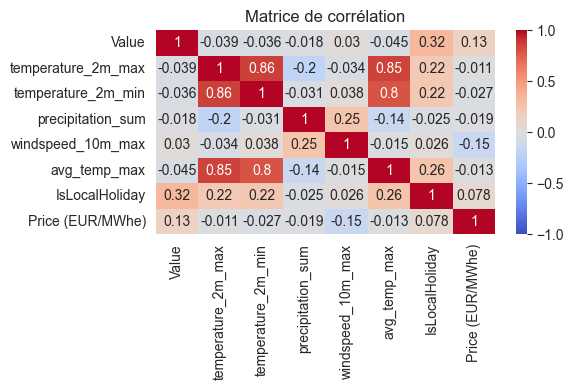

In [66]:
import bib_outils.ts as utils
utils.plot_correlation_matrix(df, columns=['Value', 'temperature_2m_max', 'temperature_2m_min',
            'precipitation_sum', 'windspeed_10m_max', 'avg_temp_max', 'IsLocalHoliday', 'Price (EUR/MWhe)'])

In [118]:
df.loc[:, ['DateUTC', 'Value', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max',
    'avg_temp_max', 'IsLocalHoliday', 'Price (EUR/MWhe)']]

,DateUTC,Value,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,avg_temp_max,IsLocalHoliday,Price (EUR/MWhe)
0,2019-01-01,553981.0,10.4,-2.1,0.0,9.5,14.17,0.0,63.240417
1,2019-01-01,553981.0,14.5,4.7,0.0,14.1,14.17,0.0,63.240417
2,2019-01-01,553981.0,15.9,3.8,0.0,10.9,14.17,0.0,63.240417
3,2019-01-01,553981.0,16.7,5.7,0.0,11.1,14.17,0.0,63.240417
4,2019-01-01,553981.0,9.6,3.1,0.0,6.2,14.17,0.0,63.240417
...,...,...,...,...,...,...,...,...,...
22965,2024-12-31,622187.0,13.6,3.7,0.0,11.5,11.76,0.0,135.421667
22966,2024-12-31,622187.0,4.2,-0.1,0.0,6.9,11.76,0.0,135.421667
22967,2024-12-31,622187.0,2.1,-3.2,0.0,5.7,11.76,0.0,135.421667
22968,2024-12-31,622187.0,15.7,6.3,0.4,15.0,11.76,0.0,135.421667


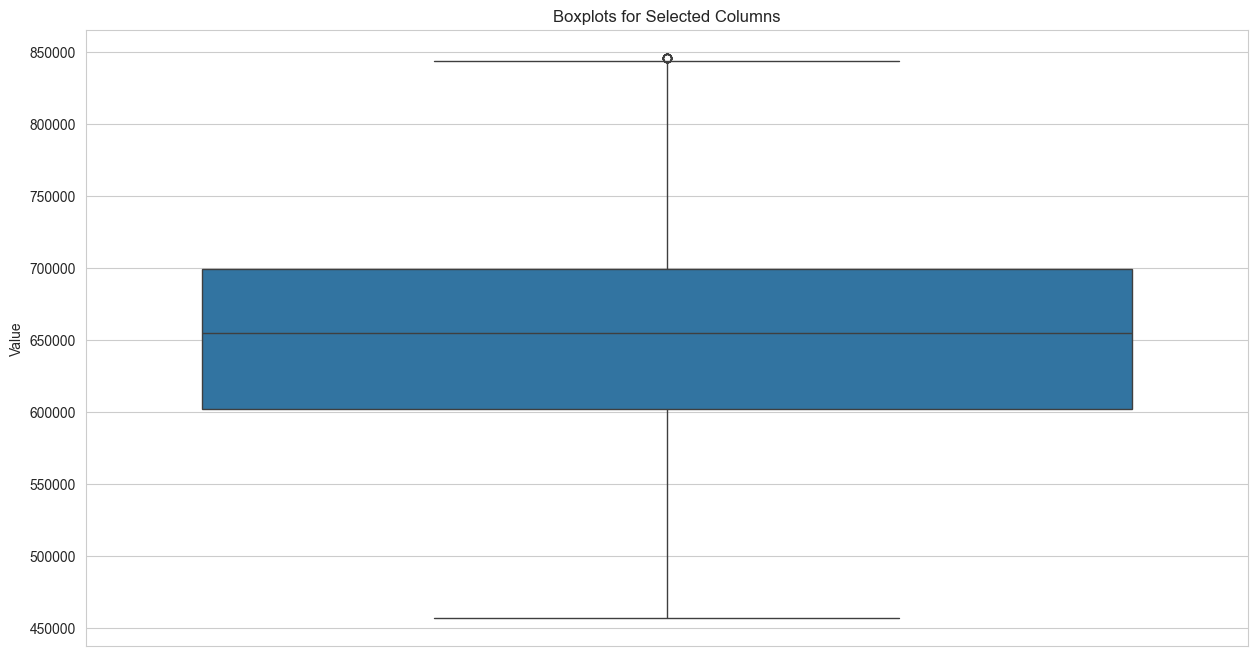

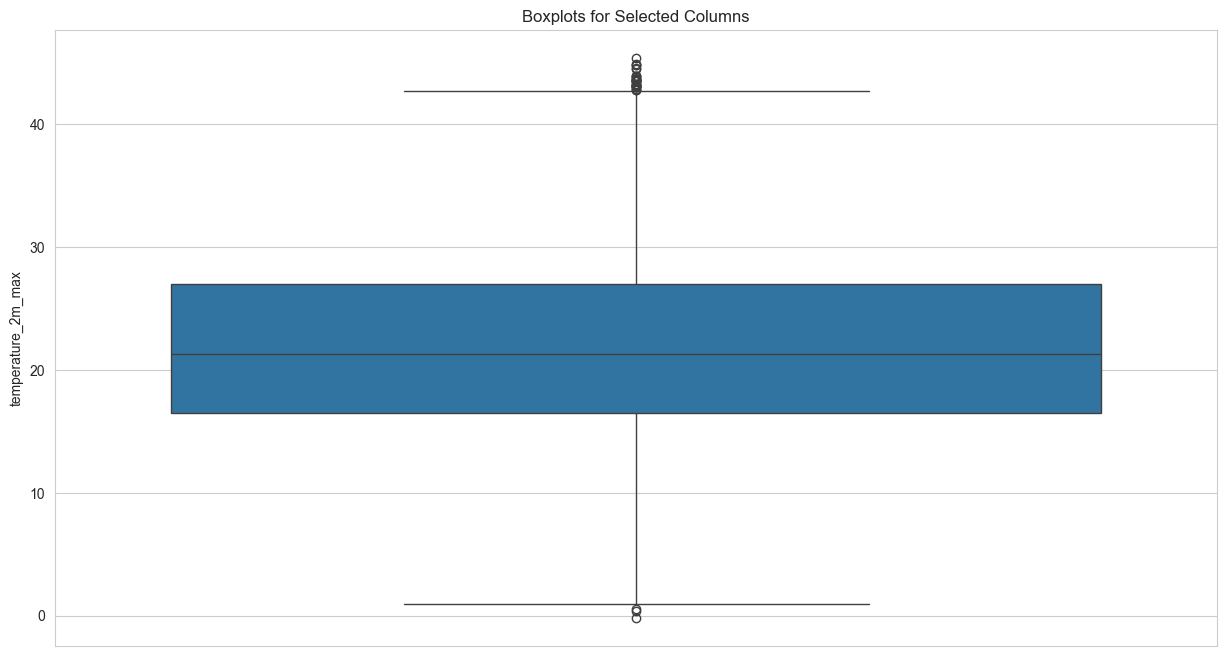

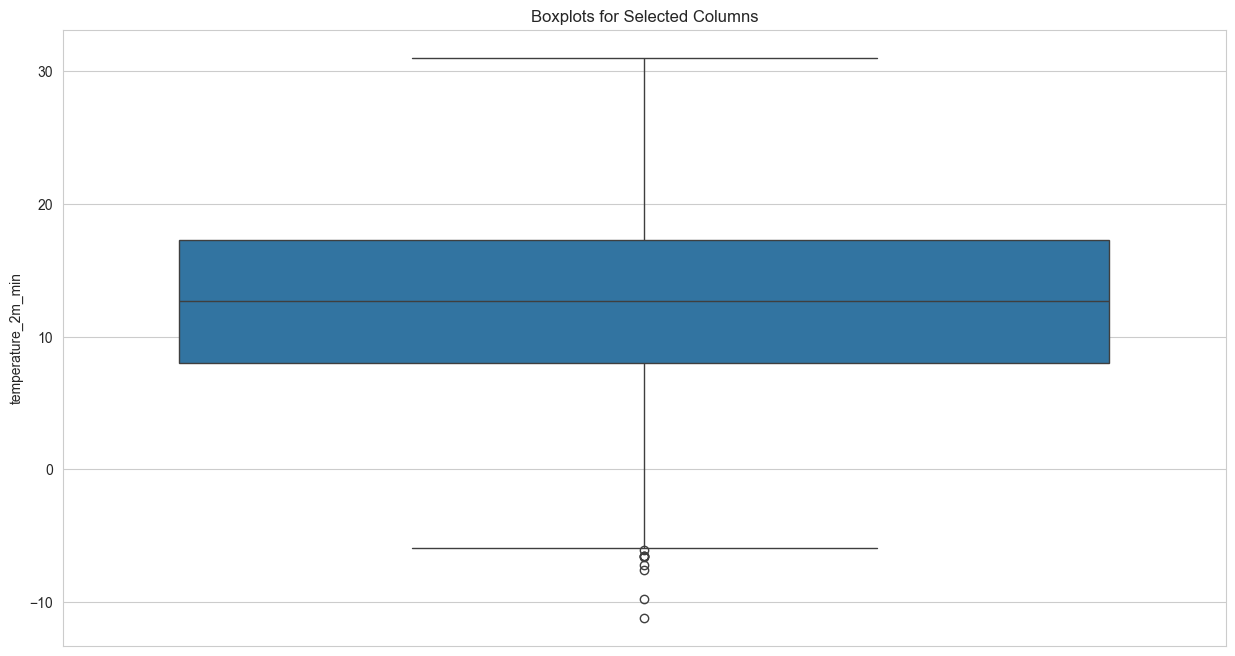

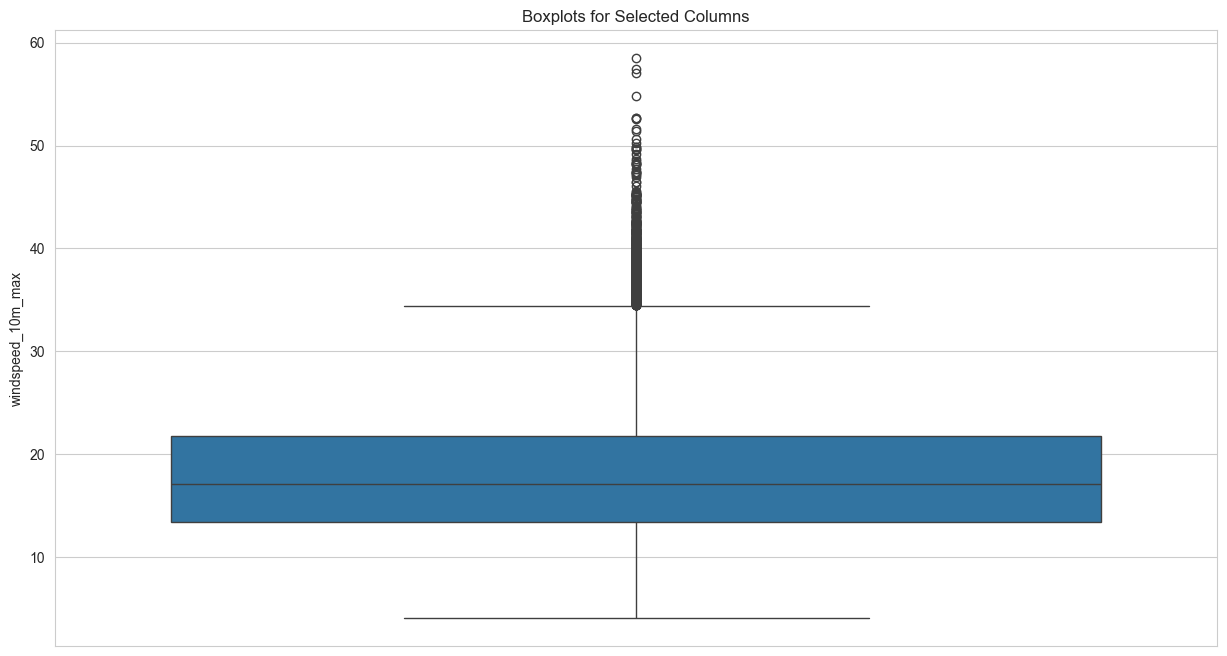

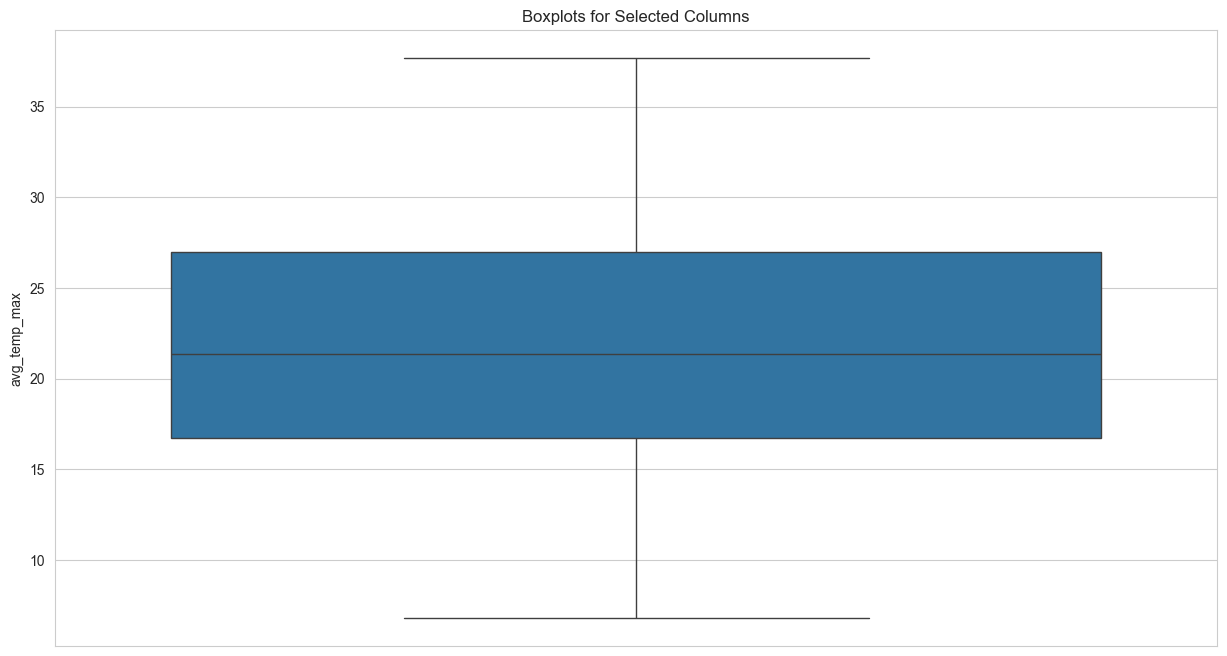

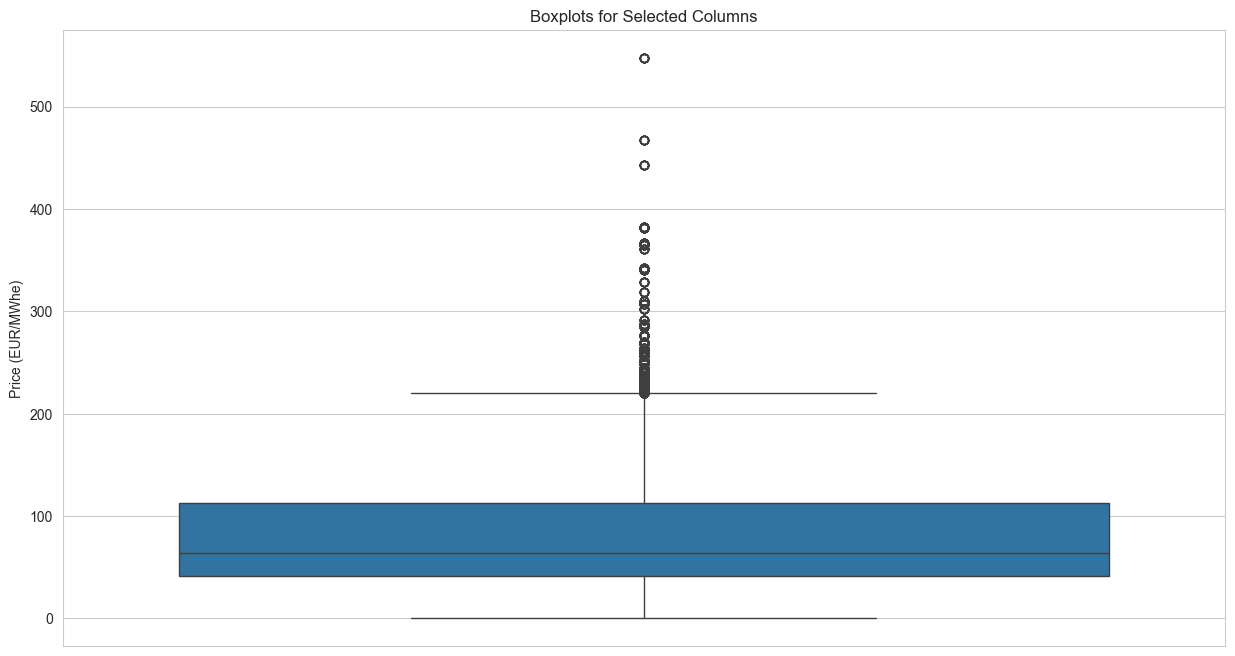

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = ['Value', 'temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max',
                   'avg_temp_max', 'Price (EUR/MWhe)']

for column in columns_to_plot:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df[column])
    plt.xticks(rotation=45)
    plt.title("Boxplots for Selected Columns")
    plt.show()

In [94]:
X, y = utils.create_dataset(df['Value'])

KeyError: 2192

In [78]:
sarima_train = df['Value'][:-365]
sarima_test = df['Value'][-365:]

sarima_model = SARIMAX(sarima_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)
sarima_predictions = sarima_result.forecast(steps=len(sarima_test))

X = df[['temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'windspeed_10m_max']]
y = df['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

sarima_rmse = np.sqrt(mean_squared_error(sarima_test, sarima_predictions))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"SARIMA RMSE: {sarima_rmse}")
print(f"XGBoost RMSE: {xgb_rmse}")

KeyError: 'DateUTC'